In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from greeks_hedge_ratio import *
from strategy_builder import *

In [ ]:
def kurt_percentile_reversion_long(df, expiry, factor, sd, threshold): # factor in string format / long slope denotes long the calls and short the puts

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]
        dte = df.loc[i, f"DTE_{expiry}"]
        atm_vol = df.loc[i, f"atm_vol_{expiry}"]/100

        gamma_hedge_ratio = (get_greeks_ratio(base_val,atm_vol,sd)["call_gamma_ratio"] + get_greeks_ratio(base_val,atm_vol,sd)["put_gamma_ratio"]) / 2

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i, f"kurt_{factor}_{expiry}"] <= threshold and df.loc[i+1, "base_change_1"] > -0.45:
                                                
            df.at[i,"positions"] = [{"strike":base_val*(1+sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},
                                    {"strike":base_val*(1-sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "call", "size": -gamma_hedge_ratio*10},  # trade the ATMs to become more vega and gamma neutral
                                    {"strike":base_val, "expiry": expiry, "option_type": "put", "size": -gamma_hedge_ratio*10}]

        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df

def kurt_percentile_reversion_short(df, expiry, factor, sd, threshold): # factor in string format / long slope denotes long the calls and short the puts

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]
        dte = df.loc[i, f"DTE_{expiry}"]
        atm_vol = df.loc[i, f"atm_vol_{expiry}"]/100

        gamma_hedge_ratio = (get_greeks_ratio(base_val,atm_vol,sd)["call_gamma_ratio"] + get_greeks_ratio(base_val,atm_vol,sd)["put_gamma_ratio"]) / 2

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i, f"kurt_{factor}_{expiry}"] >= threshold and df.loc[i+1, "base_change_1"] > -0.45:
                                                
            df.at[i,"positions"] = [{"strike":base_val*(1+sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},
                                    {"strike":base_val*(1-sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "call", "size": gamma_hedge_ratio*10},  # trade the ATMs to become more vega and gamma neutral
                                    {"strike":base_val, "expiry": expiry, "option_type": "put", "size": gamma_hedge_ratio*10}]

        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df

c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-17.494291410798297' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl


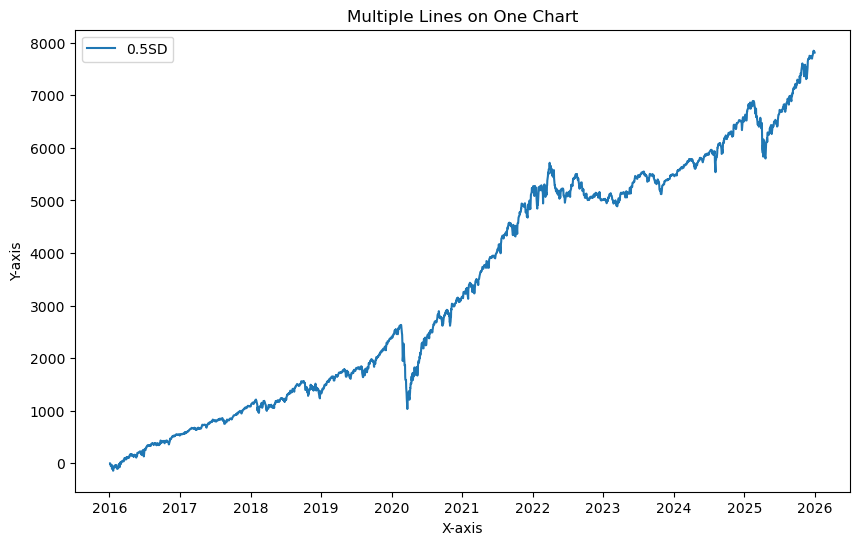

In [3]:
df = generate_polynomial("SPX")

df_strategy = kurt_percentile_reversion_short(df, 1, 1, 1, 0)
df_pnl = calculate_pnl(df_strategy)

# Plot multiple lines
plt.figure(figsize=(10, 6))
# plt.plot(spx_straddle["date"], spx_straddle["Cumulative PnL"], label='ATM')
plt.plot(df_pnl["date"], df_pnl["Cumulative PnL"], label='0.5SD')
# plt.plot(meta["date"], aapl["Cumulative PnL"] + meta["Cumulative PnL"] + tsla["Cumulative PnL"], label='total')

# Add labels, title, and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Multiple Lines on One Chart")
plt.legend()

# Show the plot
plt.show()

df = atm_straddle(df,1)
df = calculate_pnl(df)